In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/brain-tumor/brain_tumor_dataset/images.npy
/kaggle/input/brain-tumor/brain_tumor_dataset/labels.npy
/kaggle/input/brain-tumor/brain_tumor_dataset/masks.npy


**LOAD IMAGE**

In [2]:
data_image = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/images.npy",allow_pickle=True)
data_label = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/labels.npy",allow_pickle=True)
data_masks = np.load("/kaggle/input/brain-tumor/brain_tumor_dataset/masks.npy",allow_pickle=True)

In [3]:
x = data_image
y = data_label
z = data_masks

In [4]:
data = np.column_stack((x,z,y))

**SHOW IMAGE**

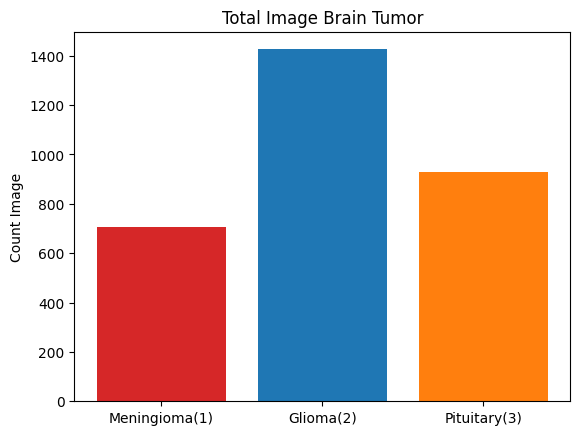

In [5]:
import matplotlib.pyplot as plt
labels, counts = np.unique(data[:,2], return_counts=True)

fig, ax = plt.subplots()

data_name = ['Meningioma(1)', 'Glioma(2)', 'Pituitary(3)']
bar_labels = ['red', 'blue','orange']
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

ax.bar(data_name, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Count Image')
ax.set_title('Total Image Brain Tumor')

plt.show()

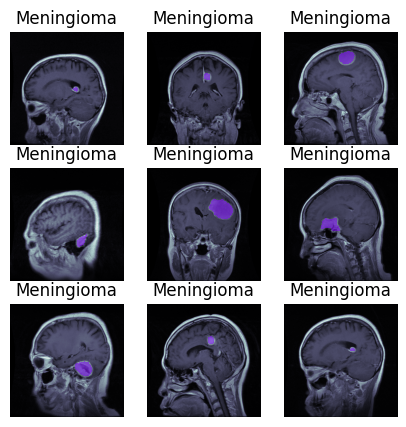

In [6]:
plt.figure(figsize=(5,5))
for i in range (9):
    plt.subplot(3,3,i+1)
    plt.imshow(data[i,0], cmap='bone')
    plt.imshow(np.ma.masked_where(data[i,1] == False, data[i,1]), cmap='rainbow', alpha=0.5)
    labels = data[i,2]
    if labels == 1:
        labels='Meningioma'
    if labels == 2:
        labels = 'Glioma'
    if labels == 3:
        labels='Pituitary'
    plt.title(labels)
    plt.axis("off")
    

**SPLITTING DATA**

In [7]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.05, random_state=1)
data_train, data_valid = train_test_split(data_train, test_size=0.2, random_state=1)

**PREPROCESSING DATA**

In [8]:
os.makedirs('/kaggle/working/Train/1')
os.makedirs('/kaggle/working/Train/2')
os.makedirs('/kaggle/working/Train/3')

os.makedirs('/kaggle/working/Validation/1')
os.makedirs('/kaggle/working/Validation/2')
os.makedirs('/kaggle/working/Validation/3')

os.makedirs('/kaggle/working/Test/1')
os.makedirs('/kaggle/working/Test/2')
os.makedirs('/kaggle/working/Test/3')

In [9]:
from matplotlib.colors import Normalize
i=1
for i in range (len(data_valid)):
    img = data_valid[i,0]
    labels = data_valid[i,2]
    norm = Normalize(vmin= img.min(), vmax = img.max())
    img = norm(img)
    img = cv2.bilateralFilter(img, 5, 75, 75)
    img = cv2.resize(img, (128, 128))
    plt.imsave('/kaggle/working/Validation/{}/{}.png'.format(labels, i), img, cmap='bone')
    i+=1

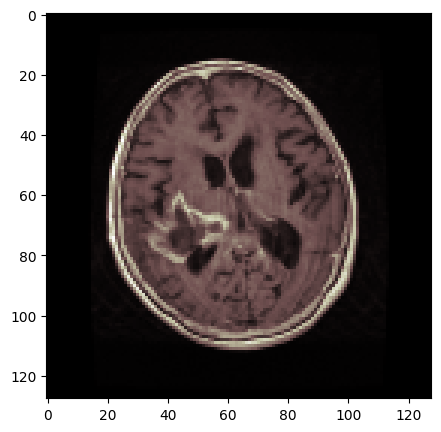

In [10]:
plt.figure(figsize=(5,5))
read_image = cv2.imread('/kaggle/working/Validation/2/558.png')
plt.imshow(read_image)
plt.show()

In [11]:
i=1
for i in range (len(data_train)):
    img = data_train[i,0]
    labels = data_train[i,2]
    norm = Normalize(vmin= img.min(), vmax = img.max())
    img = norm(img)
    img = cv2.bilateralFilter(img, 5, 75, 75)
    img = cv2.resize(img, (128, 128))
    plt.imsave('/kaggle/working/Train/{}/{}.png'.format(labels, i), img, cmap='bone')
    i+=1

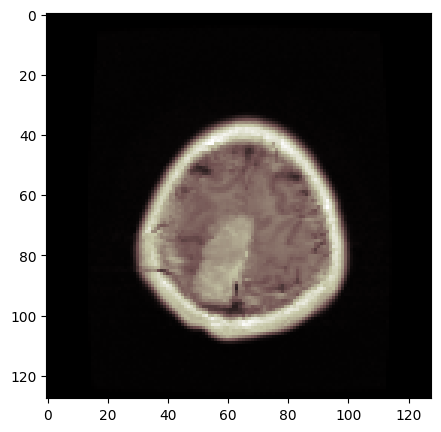

In [12]:
plt.figure(figsize=(5,5))
read_image = cv2.imread('/kaggle/working/Train/1/1465.png')
plt.imshow(read_image)
plt.show()

In [13]:
i=1
for i in range (len(data_test)):
    img = data_test[i,0]
    labels = data_test[i,2]
    norm = Normalize(vmin= img.min(), vmax = img.max())
    img = norm(img)
    img = cv2.bilateralFilter(img, 5, 75, 75)
    img = cv2.resize(img, (128, 128))
    plt.imsave('/kaggle/working/Test/{}/{}.png'.format(labels, i), img, cmap='bone')
    i+=1

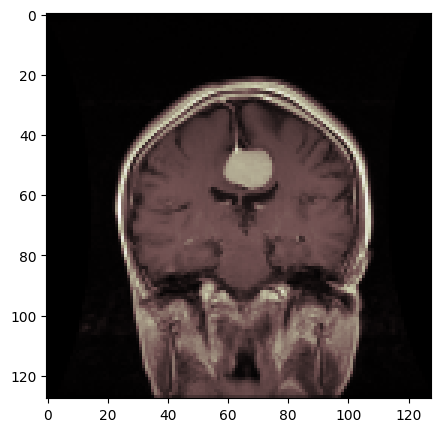

In [14]:
plt.figure(figsize=(5,5))
read_image = cv2.imread('/kaggle/working/Test/1/130.png')
plt.imshow(read_image)
plt.show()

In [15]:
read_image.shape

(128, 128, 3)

**NORMALIZATION DATA and AUGMENTATION DATA**

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   vertical_flip=True,
                                   rotation_range=45,
                                   horizontal_flip = True)
training_set = train_data_generator.flow_from_directory('/kaggle/working/Train',
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 color_mode='rgb',
                                                 class_mode = 'categorical')

Found 2328 images belonging to 3 classes.


In [17]:
valid_data_generator = ImageDataGenerator(rescale = 1./255)
valid_set = valid_data_generator.flow_from_directory('/kaggle/working/Validation',
                                            target_size = (128,128),
                                            batch_size = 32,
                                            color_mode='rgb',
                                            class_mode = 'categorical')

Found 582 images belonging to 3 classes.


from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_filp=True,
                                   rotation_range=10,                        
                                   width_shift_range=0.05,
                                   height_shift_range=0.05)
training_set = train_data_generator.flow_from_directory('/kaggle/working/Train',
                                                         target_size = (128, 128),
                                                         batch_size = 32,
                                                         class_mode = 'categorical')
valid_data_gen = ImageDataGenerator(rescale = 1./255)
valid_set = valid_data_gen.flow_from_directory('/kaggle/working/Validation',
                                                target_size = (128,128),
                                                batch_size = 32,
                                                class_mode = 'categorical')

In [18]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3,activation='softmax'))

In [19]:
#model.summary()

In [20]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(training_set, epochs=40, 
                    validation_data=(valid_set))

Epoch 1/40


2023-11-26 07:22:11.803830: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


73/73 [==============================] - 25s 168ms/step - loss: 1.1136 - accuracy: 0.5773 - val_loss: 1.0743 - val_accuracy: 0.4622
Epoch 2/40
73/73 [==============================] - 12s 162ms/step - loss: 0.7639 - accuracy: 0.6589 - val_loss: 1.0483 - val_accuracy: 0.4622
Epoch 3/40
73/73 [==============================] - 12s 160ms/step - loss: 0.6880 - accuracy: 0.6830 - val_loss: 1.0230 - val_accuracy: 0.4622
Epoch 4/40
73/73 [==============================] - 12s 166ms/step - loss: 0.6155 - accuracy: 0.7023 - val_loss: 0.9638 - val_accuracy: 0.5636
Epoch 5/40
73/73 [==============================] - 12s 163ms/step - loss: 0.6221 - accuracy: 0.6916 - val_loss: 0.8893 - val_accuracy: 0.5979
Epoch 6/40
73/73 [==============================] - 12s 162ms/step - loss: 0.5981 - accuracy: 0.7242 - val_loss: 0.8134 - val_accuracy: 0.5636
Epoch 7/40
73/73 [==============================] - 12s 160ms/step - loss: 0.5765 - accuracy: 0.7328 - val_loss: 0.8398 - val_accuracy: 0.6117
Epoch 8/40

In [21]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


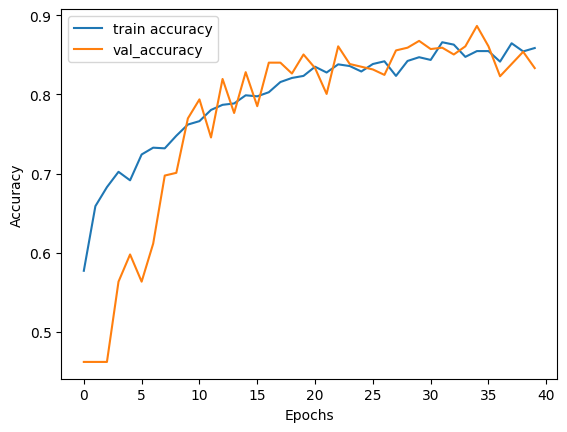

In [22]:
plt.plot(train_acc, label="train accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

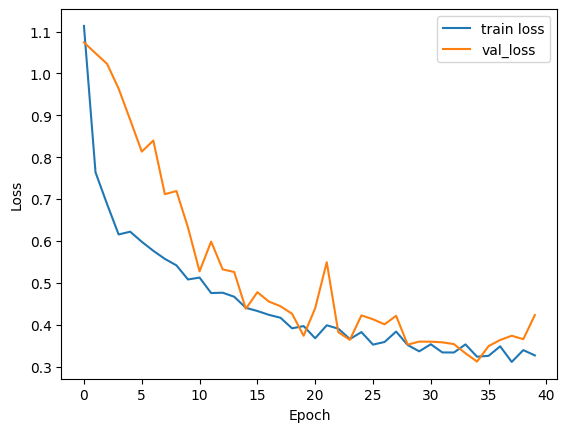

In [23]:
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
test_data_generator = ImageDataGenerator(rescale = 1./255)
test_set = test_data_generator.flow_from_directory('/kaggle/working/Test',
                                            target_size = (128,128),
                                            batch_size = 32,       
                                            color_mode='rgb',
                                            shuffle=False,
                                            class_mode = 'categorical')

Found 154 images belonging to 3 classes.


In [25]:
y_pred=model.predict(test_set)

5/5 [==============================] - 1s 122ms/step


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
y_true = test_set.classes
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2]


In [27]:
y_pred_arg = np.argmax(y_pred, axis=1)

In [28]:
print(y_pred_arg)

[0 2 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1
 2 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 0 2 2 2
 2 2 2 2 2 0]


In [29]:
CM = confusion_matrix(y_true, y_pred_arg)

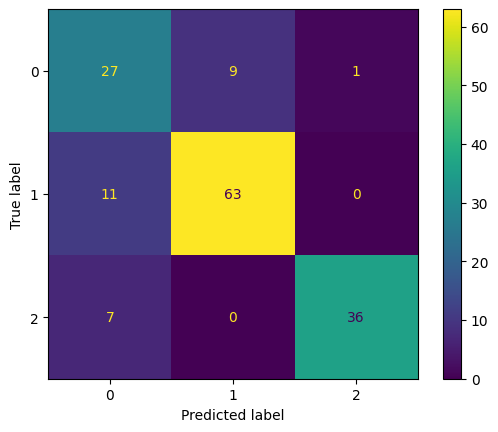

In [30]:
ConfusionMatrixDisplay(CM).plot()

In [31]:
print(classification_report(y_true, y_pred_arg))

              precision    recall  f1-score   support

           0       0.60      0.73      0.66        37
           1       0.88      0.85      0.86        74
           2       0.97      0.84      0.90        43

    accuracy                           0.82       154
   macro avg       0.82      0.81      0.81       154
weighted avg       0.84      0.82      0.82       154

